In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
images_path = r'/content/drive/MyDrive/ColabNotebooks/tufs_dental_databse/Radiographs'

In [5]:
masks_path = r'/content/drive/MyDrive/ColabNotebooks/tufs_dental_databse/Segmentation/teeth_mask'

In [6]:
files = os.listdir(images_path)
print(files)


['1027.JPG', '239.JPG', '290.JPG', '302.JPG', '244.JPG', '344.JPG', '1000.JPG', '14.JPG', '372.JPG', '1016.JPG', '138.JPG', '197.JPG', '1013.JPG', '368.JPG', '392.JPG', '124.JPG', '177.JPG', '205.JPG', '316.JPG', '278.JPG', '351.JPG', '31.JPG', '337.JPG', '315.JPG', '314.JPG', '333.JPG', '247.JPG', '335.JPG', '19.JPG', '1036.JPG', '16.JPG', '100.JPG', '241.JPG', '11.JPG', '159.JPG', '174.JPG', '140.JPG', '225.JPG', '113.JPG', '127.JPG', '1043.JPG', '36.JPG', '346.JPG', '272.JPG', '343.JPG', '231.JPG', '1030.JPG', '230.JPG', '128.JPG', '105.JPG', '1009.JPG', '194.JPG', '190.JPG', '162.JPG', '359.JPG', '224.JPG', '1008.JPG', '29.JPG', '154.JPG', '201.JPG', '243.JPG', '332.JPG', '144.JPG', '198.JPG', '353.JPG', '329.JPG', '365.JPG', '1037.JPG', '393.JPG', '301.JPG', '188.JPG', '196.JPG', '399.JPG', '104.JPG', '362.JPG', '281.JPG', '147.JPG', '328.JPG', '394.JPG', '28.JPG', '189.JPG', '367.JPG', '115.JPG', '276.JPG', '121.JPG', '26.JPG', '258.JPG', '109.JPG', '294.JPG', '381.JPG', '157.JPG

In [7]:
def load_data(image_folder, mask_folder, size, img_size=(256, 256)):
    images = []
    masks = []

    for filename in os.listdir(image_folder):
        filename_lower = filename.lower()
        img = Image.open(os.path.join(image_folder, filename)).convert('L')
        img = img.resize(img_size)
        img = np.array(img) / 255.0  # normalize
        images.append(img)

        mask = Image.open(os.path.join(mask_folder, filename_lower)).convert('L')
        mask = mask.resize(img_size)
        mask = np.array(mask) / 255.0  # normalize
        masks.append(mask)

        if len(images) == size and len(masks) == size:
            break

    images = np.expand_dims(images, axis=-1)
    masks = np.expand_dims(masks, axis=-1)
    return np.array(images), np.array(masks)

In [8]:
images, masks = load_data(images_path, masks_path, size=2000)

In [9]:
images.shape, masks.shape

((1000, 256, 256, 1), (1000, 256, 256, 1))

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model


def unet_model():
    inputs = Input(shape=(256, 256, 1))

    # Encoder path
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    # Output layer with a single channel for binary mask prediction
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Model
    model = Model(inputs, outputs)
    return model

In [12]:
unet = unet_model()

In [13]:
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 512)    │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 768)    │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 7,846,081 (29.93 MB)

 Trainable params: 7,846,081 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    filepath='../checkpoints/tufs_unet_segmentation-{epoch:02d}.keras',
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,               # Number of epochs with no improvement after which to stop
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored metric
)


In [ ]:
# from keras.models import load_model

# unet = load_model(r'D:\_DOCUMENTE_RARES\Desktop\ortho-vision\ai\models\tufs_unet_segmentation.h5')
# unet.summary()

In [21]:

history = unet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
)


Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 560ms/step - accuracy: 0.9085 - loss: 0.1458 - val_accuracy: 0.9086 - val_loss: 0.1438
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 553ms/step - accuracy: 0.9086 - loss: 0.1437 - val_accuracy: 0.9020 - val_loss: 0.1606
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 558ms/step - accuracy: 0.9061 - loss: 0.1528 - val_accuracy: 0.9083 - val_loss: 0.1484
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 580ms/step - accuracy: 0.9096 - loss: 0.1468 - val_accuracy: 0.9114 - val_loss: 0.1415
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 567ms/step - accuracy: 0.9127 - loss: 0.1372 - val_accuracy: 0.9113 - val_loss: 0.1405
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 569ms/step - accuracy: 0.9138 - loss: 0.1359 - val_accuracy: 0.9143 - val_loss: 0.1426
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 573ms/step - accuracy: 0.9152 - loss: 0.1329 - val_accuracy: 0.9192 - val_loss: 0.1243
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 577ms/step - accuracy: 0.9217 - loss: 0.1161 - val_accu

In [22]:
unet.save(r'/content/drive/MyDrive/ColabNotebooks/tufs_unet_segmentation.keras')

In [23]:
val_loss, val_accuracy = unet.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9459 - loss: 0.0600
Validation Loss: 0.05917017161846161, Validation Accuracy: 0.9461471438407898


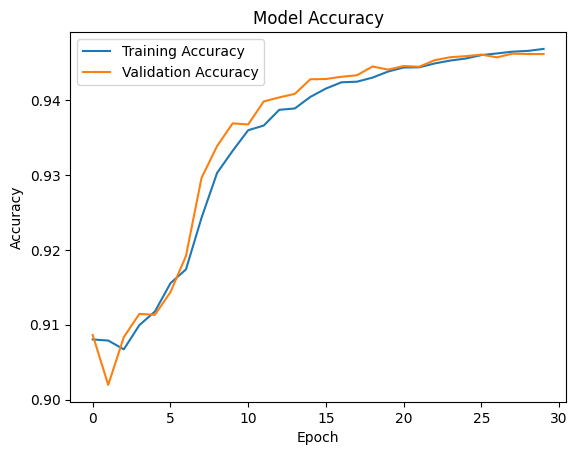

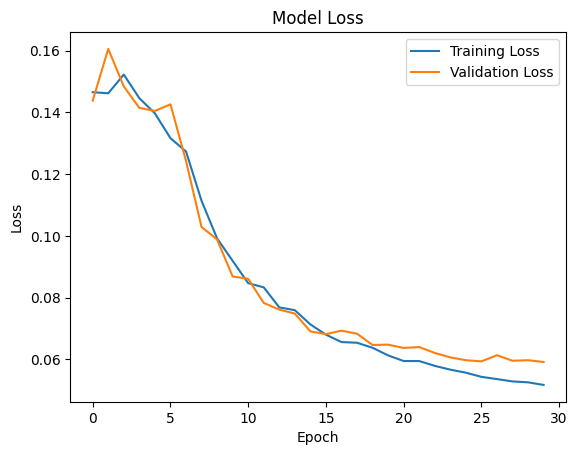

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()


In [25]:
def visualize_predictions(X, y_true, y_pred, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Display original image
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Display true mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Display predicted mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


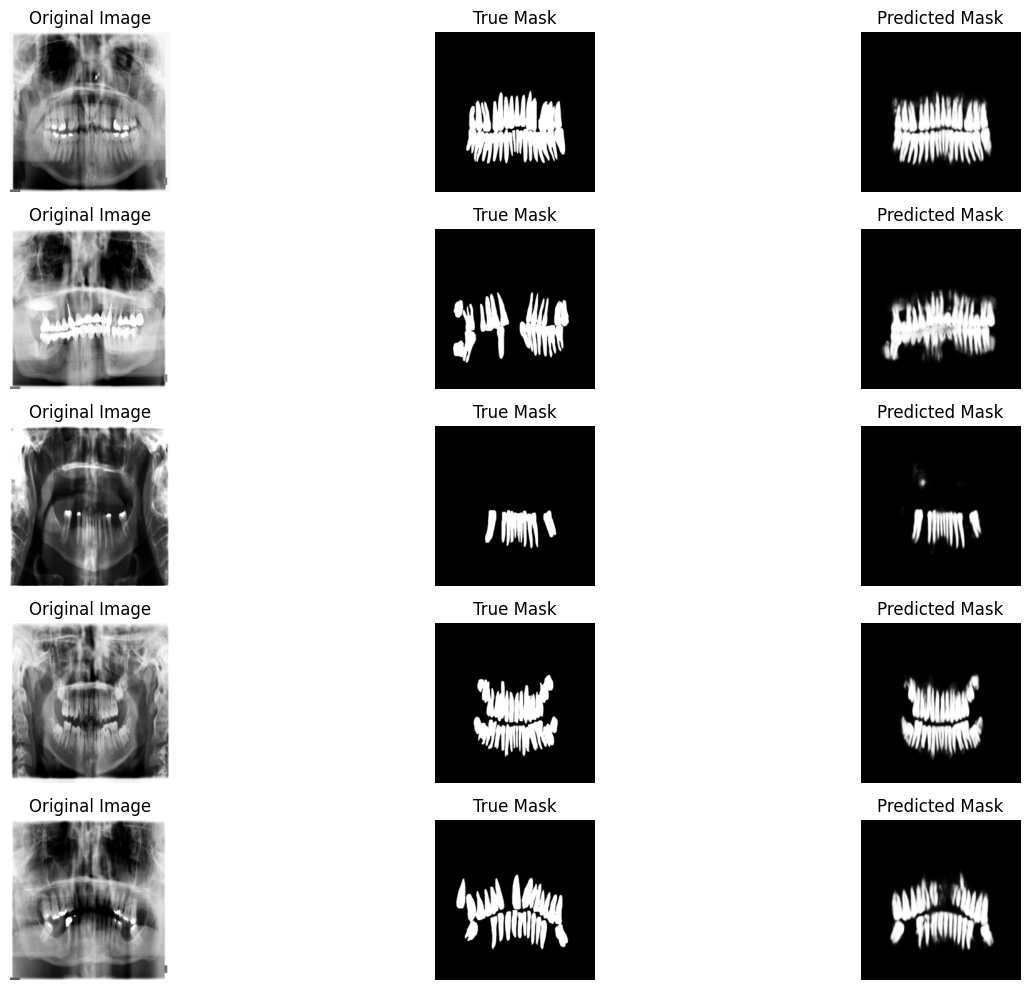

In [26]:
predictions = unet.predict(X_val)
visualize_predictions(X_val, y_val, predictions)